### lib and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import datetime

In [2]:
import talib

In [3]:
import yfinance as yf

tk = yf.Tickers(["^IXIC", "^GSPC"])
df = tk.history(period="max", interval="1d", auto_adjust=False)

print(f"{df.shape = }")

[*********************100%***********************]  2 of 2 completed

df.shape = (24579, 16)


In [4]:
ndq_bars = df.xs("^IXIC", level=1, axis=1).copy()
ndq_bars.columns = [c.lower().replace(" ", "_") for c in ndq_bars.columns]
print(ndq_bars.shape)
print(ndq_bars.head().to_string())

(24579, 8)
            adj_close  close  dividends  high  low  open  stock_splits  volume
Date                                                                          
1927-12-30        NaN    NaN        NaN   NaN  NaN   NaN           NaN     NaN
1928-01-03        NaN    NaN        NaN   NaN  NaN   NaN           NaN     NaN
1928-01-04        NaN    NaN        NaN   NaN  NaN   NaN           NaN     NaN
1928-01-05        NaN    NaN        NaN   NaN  NaN   NaN           NaN     NaN
1928-01-06        NaN    NaN        NaN   NaN  NaN   NaN           NaN     NaN


In [5]:
snp_bars = df.xs("^GSPC", level=1, axis=1).copy()
snp_bars.columns = [c.lower().replace(" ", "_") for c in snp_bars.columns]
print(snp_bars.shape)
print(snp_bars.head().to_string())

(24579, 8)
            adj_close      close  dividends       high        low       open  stock_splits  volume
Date                                                                                              
1927-12-30  17.660000  17.660000        0.0  17.660000  17.660000  17.660000           0.0       0
1928-01-03  17.760000  17.760000        0.0  17.760000  17.760000  17.760000           0.0       0
1928-01-04  17.719999  17.719999        0.0  17.719999  17.719999  17.719999           0.0       0
1928-01-05  17.549999  17.549999        0.0  17.549999  17.549999  17.549999           0.0       0
1928-01-06  17.660000  17.660000        0.0  17.660000  17.660000  17.660000           0.0       0


<Axes: title={'center': 'S&P 500 Closing Prices'}, xlabel='Date'>

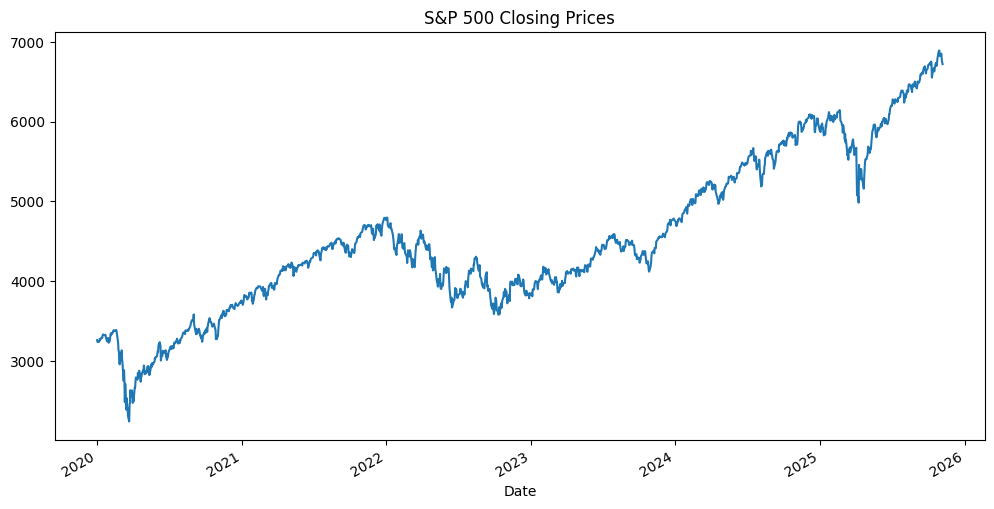

In [6]:
snp_bars.loc["2020-01-01":, "close"].plot(
    title="S&P 500 Closing Prices", figsize=(12, 6)
)

### indicators - overlap studies

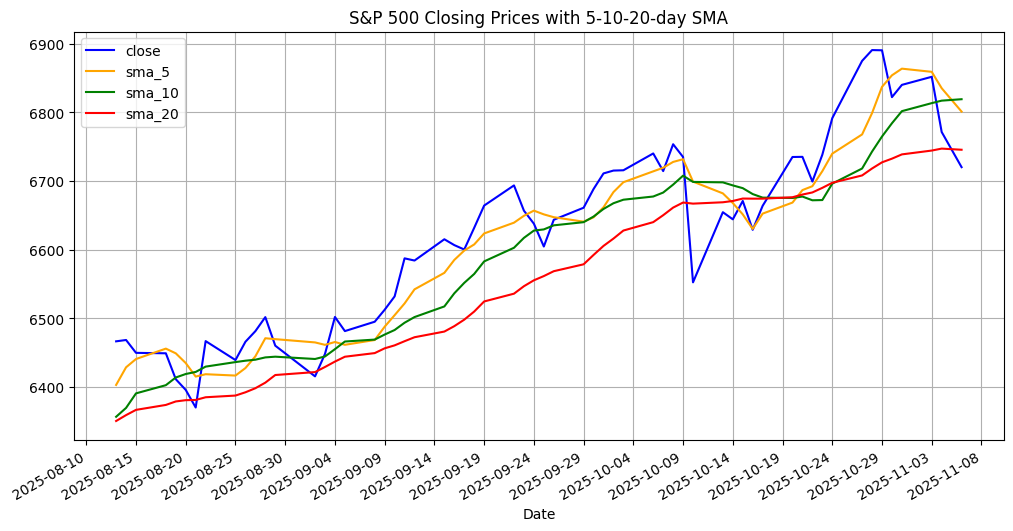

In [46]:
paras = 5, 10, 20
snp_bars[f"sma_{paras[0]}"] = talib.SMA(snp_bars["close"], timeperiod=paras[0])
snp_bars[f"sma_{paras[1]}"] = talib.SMA(snp_bars["close"], timeperiod=paras[1])
snp_bars[f"sma_{paras[2]}"] = talib.SMA(snp_bars["close"], timeperiod=paras[2])

ax = snp_bars.tail(60).plot(
    y=["close", f"sma_{paras[0]}", f"sma_{paras[1]}", f"sma_{paras[2]}"],
    title=f"S&P 500 Closing Prices with {paras[0]}-{paras[1]}-{paras[2]}-day SMA",
    figsize=(12, 6),
    color=["blue", "orange", "green", "red"],
    legend=True,
    grid=True,
)
ax.xaxis.set_major_locator(mpl.dates.DayLocator(interval=5))

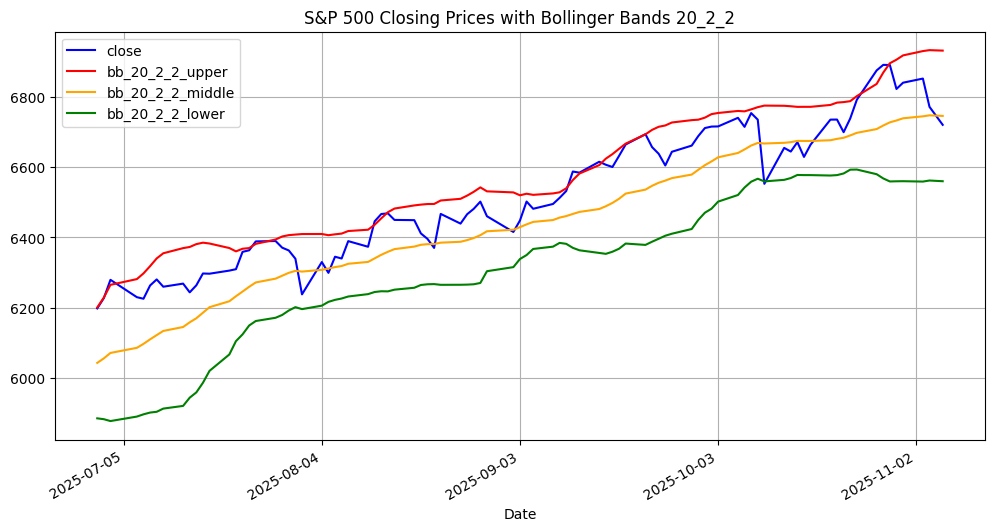

In [47]:
para_bb = (20, 2, 2)
para_comb = "_".join(map(str, para_bb))

(
    snp_bars[f"bb_{para_comb}_upper"],
    snp_bars[f"bb_{para_comb}_middle"],
    snp_bars[f"bb_{para_comb}_lower"],
) = talib.BBANDS(
    snp_bars["close"],
    timeperiod=para_bb[0],
    nbdevup=para_bb[1],
    nbdevdn=para_bb[2],
    matype=0,
)

ax = snp_bars.tail(90).plot(
    y=[
        "close",
        f"bb_{para_comb}_upper",
        f"bb_{para_comb}_middle",
        f"bb_{para_comb}_lower",
    ],
    title=f"S&P 500 Closing Prices with Bollinger Bands {para_comb}",
    figsize=(12, 6),
    color=["blue", "red", "orange", "green"],
    legend=True,
    grid=True,
)
ax.xaxis.set_major_locator(mpl.dates.DayLocator(interval=30))

### indicators - momentum

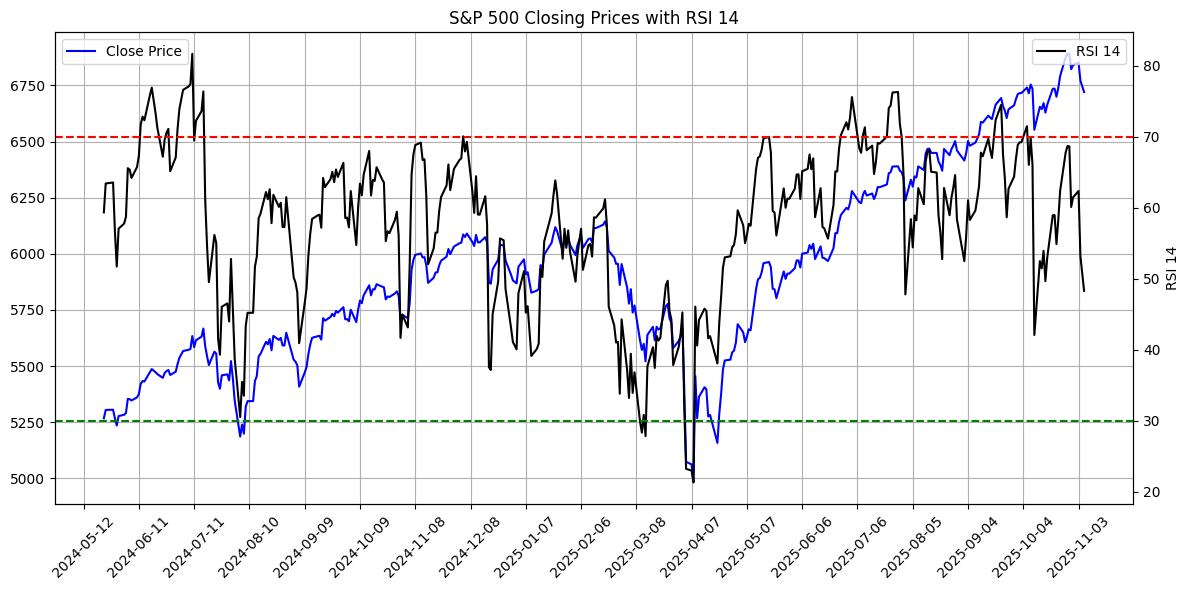

In [23]:
para = 14

snp_bars[f"rsi_{para}"] = talib.RSI(snp_bars["close"], timeperiod=para)

pdf = snp_bars.tail(365)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pdf.index, pdf["close"], color="blue", label="Close Price")
ax2 = ax.twinx()
ax2.plot(pdf.index, pdf[f"rsi_{para}"], color="black", label=f"RSI {para}")
ax2.axhline(70, color="red", linestyle="--")
ax2.axhline(30, color="green", linestyle="--")

ax.set_title(f"S&P 500 Closing Prices with RSI {para}")
ax2.set_ylabel(f"RSI {para}")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.xaxis.set_major_locator(mpl.dates.DayLocator(interval=30))
ax.tick_params(axis="x", rotation=45)
ax.grid(True)
plt.tight_layout()

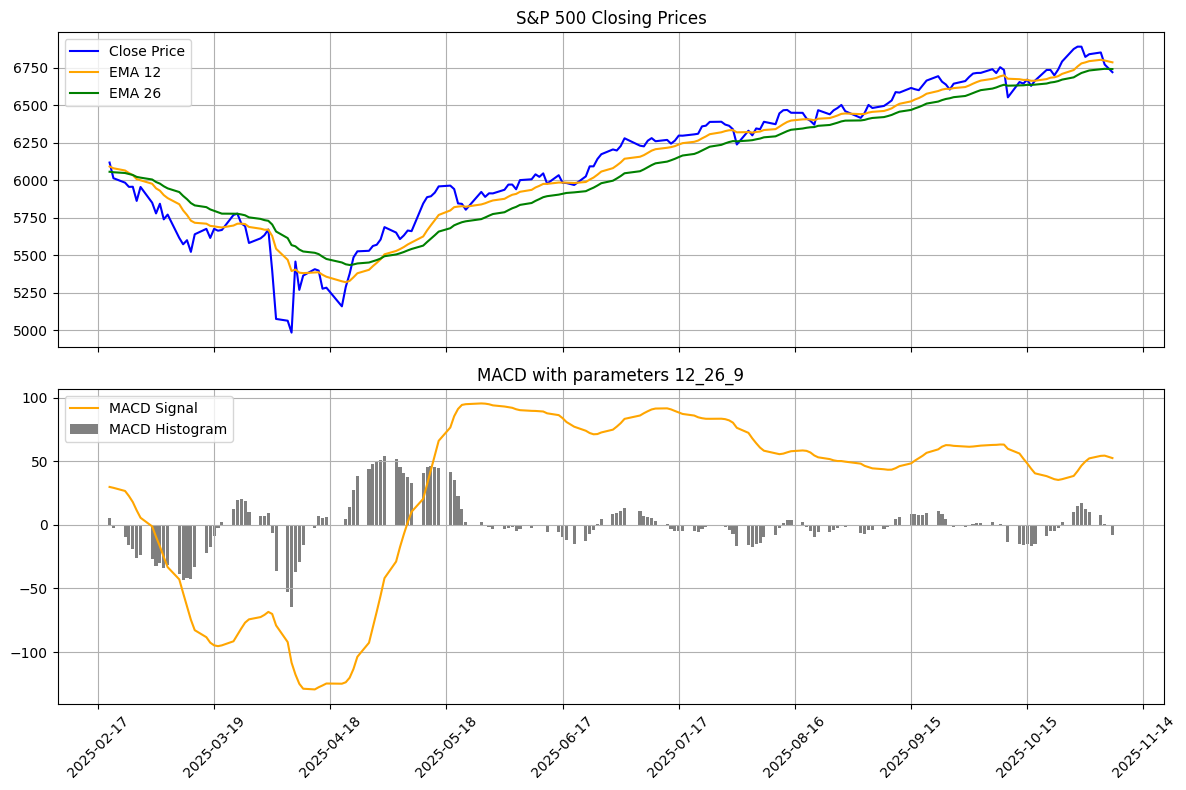

In [39]:
paras = (12, 26, 9)
para_comb = "_".join(map(str, paras))

_, snp_bars[f"macd_sig_{para_comb}"], snp_bars[f"macd_hist_{para_comb}"] = talib.MACD(
    snp_bars["close"], fastperiod=paras[0], slowperiod=paras[1], signalperiod=paras[2]
)
snp_bars[f"ema_{paras[0]}"] = talib.EMA(snp_bars["close"], timeperiod=paras[0])
snp_bars[f"ema_{paras[1]}"] = talib.EMA(snp_bars["close"], timeperiod=paras[1])

pdf = snp_bars.tail(180)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(pdf.index, pdf["close"], color="blue", label="Close Price")
ax1.plot(pdf.index, pdf[f"ema_{paras[0]}"], color="orange", label=f"EMA {paras[0]}")
ax1.plot(pdf.index, pdf[f"ema_{paras[1]}"], color="green", label=f"EMA {paras[1]}")
ax1.legend(loc="upper left")
ax1.set_title("S&P 500 Closing Prices")
ax1.grid(True)

ax2.plot(pdf.index, pdf[f"macd_sig_{para_comb}"], color="orange", label="MACD Signal")
ax2.bar(pdf.index, pdf[f"macd_hist_{para_comb}"], color="gray", label="MACD Histogram")
ax2.set_title(f"MACD with parameters {para_comb}")
ax2.legend(loc="upper left")
ax2.xaxis.set_major_locator(mpl.dates.DayLocator(interval=30))
ax2.tick_params(axis="x", rotation=45)
ax2.grid(True)

plt.tight_layout()